In [232]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import ToTensor
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


In [233]:
# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),)
        
        self.decoder = nn.Sequential(nn.Linear(10, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh())
    
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
        


In [234]:
class CNN_autoencoder(nn.Module):
    def __init__(self):
        super(CNN_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # (b, 16, 10, 10)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # (b, 16, 5, 5)
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # (b, 8, 3, 3)
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # (b, 8, 2, 2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # (b, 16, 5, 5)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # (b, 8, 15, 15)
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # (b, 1, 28, 28)
            nn.Tanh()
        )
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode

In [235]:
# 设置训练参数
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 128
learning_rate = 1e-4
num_epochs = 1000


In [236]:
class autoencoder_Dataset(Dataset):
    
    def __init__(self, data):
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image = self.data[:, index].reshape(1, 28, 28)
        label = 0  # 由于没有标签信息，这里使用了一个默认标签
        return image, label

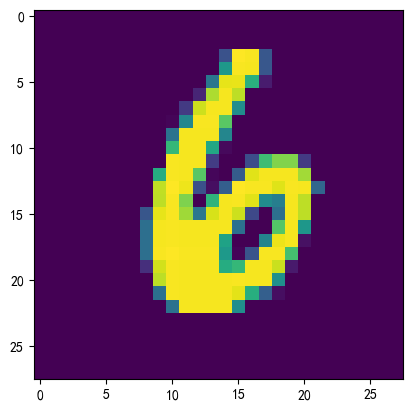

(784, 5000)

In [237]:
# 载入npy文件
data = np.load("x.npy")
# 使用Matplotlib可视化数据
ex = data[:,0].reshape((28,28))
plt.imshow(ex)
plt.show()
data.shape

In [238]:
# 加载 MNIST 数据集
train_x = np.load("x.npy")
train_x = train_x / 255.0  # 将像素值缩放到 [0, 1] 范围内
dataset = autoencoder_Dataset(train_x)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 创建自编码器模型
model = Autoencoder().to(device)
# model = CNN_autoencoder().to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [239]:

def trainer(train_loader, model,n_epochs , device):
    loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        for x, _ in train_loader:
            # forward
            x = x.reshape(-1, 28*28)
            x = x.to(device) 
            _, output = model(x)
            loss = criterion(output, x)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()                    # Update parameters.
        train_loss = loss.detach().item()
        loss_record.append(train_loss)
        mean_train_loss = sum(loss_record) / len(loss_record)
        if(epoch+1)%50==0:
            print(f'Epoch[{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss: .8f}')
    return loss_record

def CNN_trainer(train_loader, model,n_epochs , device):
    loss_record = []
    for epoch in range(n_epochs):
        model.train()  # Set your model to train mode.
        for x, _ in train_loader:
            # forward
            x = x.reshape(-1, 1, 28, 28)
            x = x.to(device) 
            _, output = model(x)
            loss = criterion(output, x)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()                    # Update parameters.
        train_loss = loss.detach().item()
        loss_record.append(train_loss)
        mean_train_loss = sum(loss_record) / len(loss_record)
        if(epoch+1)%50==0:
            print(f'Epoch[{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss: .8f}')
    return loss_record

Epoch[50/1000]: Train loss:  0.07152140
Epoch[100/1000]: Train loss:  0.05923015
Epoch[150/1000]: Train loss:  0.05244430
Epoch[200/1000]: Train loss:  0.04815668
Epoch[250/1000]: Train loss:  0.04511243
Epoch[300/1000]: Train loss:  0.04297494
Epoch[350/1000]: Train loss:  0.04113822
Epoch[400/1000]: Train loss:  0.03968457
Epoch[450/1000]: Train loss:  0.03834630
Epoch[500/1000]: Train loss:  0.03736215
Epoch[550/1000]: Train loss:  0.03648042
Epoch[600/1000]: Train loss:  0.03568046
Epoch[650/1000]: Train loss:  0.03501644
Epoch[700/1000]: Train loss:  0.03444736
Epoch[750/1000]: Train loss:  0.03391016
Epoch[800/1000]: Train loss:  0.03341535
Epoch[850/1000]: Train loss:  0.03299394
Epoch[900/1000]: Train loss:  0.03262166
Epoch[950/1000]: Train loss:  0.03224507
Epoch[1000/1000]: Train loss:  0.03189996


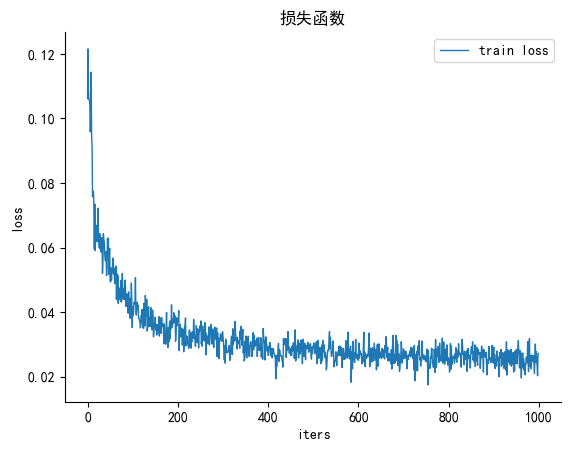

In [240]:
#改变函数调用选择不同训练
y_train_loss = trainer(dataloader,model,num_epochs,device)     # loss值，即y轴
x_train_loss = range(len(y_train_loss))			 # loss的数量，即x轴
plt.figure()

# 去除顶部和右边框框
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置字体
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号

plt.xlabel('iters')    # x轴标签
plt.ylabel('loss')     # y轴标签

# 以x_train_loss为横坐标，y_train_loss为纵坐标，曲线宽度为1，实线，增加标签，训练损失，
plt.plot(x_train_loss, y_train_loss, linewidth=1,linestyle="solid", label="train loss")
plt.legend()
plt.title("损失函数")
plt.show()
# 保存训练后的模型
torch.save(model.state_dict(), 'autoencoder.ckpt')

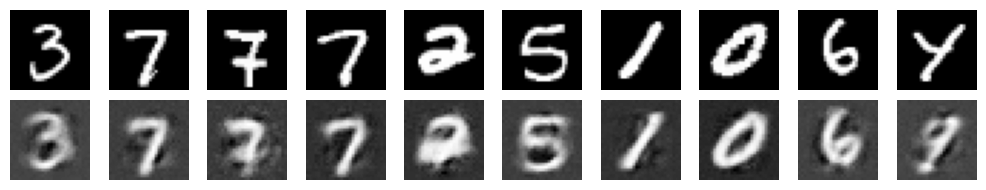

In [244]:
# 将测试图像输入自编码器并生成重构图像
images, _ = next(iter(dataloader))
#这里要改一下如果是CNN_trainer的话reshape(-1, 1, 28, 28)
images = images.reshape(-1, 28*28)
images = images.to('cuda:0')  # 将输入数据移动到 GPU 上
_,reconstructed_images = model(images)

# 将张量转换为图像并显示
original_images = images.view(-1, 1, 28, 28).cpu().detach().numpy()
reconstructed_images = reconstructed_images.view(-1, 1, 28, 28).cpu().detach().numpy()

fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(10, 2))

# 显示原始图像
for i, ax in enumerate(axes[0]):
    ax.imshow(original_images[i].squeeze(), cmap='gray')
    ax.axis('off')

# 显示重构图像
for i, ax in enumerate(axes[1]):
    ax.imshow(reconstructed_images[i].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()